# Testing `hera_pspec` with EoR and Diffuse Foregrounds

Steven Murray, Jovanni Castaneda, Bobby Pascua, Zachary Martinot, and the HERA Validation Team

## Setup and Metadata

### Abstract

We simulate ideal, noiseless observations of a sky with a $1/k^2$ EoR power spectrum and a GSM2008 foreground sky model with `RIMEz`. The EoR part of the sky is the same simulation as used in Step 0.2.0.

We then run a fiducial `hera_pspec` pipeline over the simulation, ensuring that outside the wedge region the power spectrum is unbiased as compared to the known analytic input to the level of 1%. 

### Imports

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os
import copy
import glob
import sys

import astropy
import astropy.units as units
import h5py

import hera_pspec
import pyuvdata
import uvtools

from pyuvdata import UVData, UVBeam
from hera_cal import io
from hera_pspec.data import DATA_PATH as PSPEC_DATA_PATH

sys.path.append("../../")
import template_tools
import pathlib
from collections import defaultdict

### Description

In [3]:
print(f"Last executed: {datetime.now()}")

Last executed: 2020-02-10 08:45:38.791755


- **Major Step Description:** Simulate visibilities of diffuse foregrounds diffuse + $1/k^2$ EoR power spectrum. Extract power spectrum estimates with `hera_pspec`.
- **Minor Variation Description:** Use GSM to provide foregrounds, simulated by `RIMEz`.
- **Pipelines Tested:** `pspec`
- **Criteria**:
  1. Residuals to known analytic input EoR PS within 1% after incoherent averaging over 8 hours, outside wedge. 
  

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. {Test results for criteria 1}
2. {Test results for criteria 2...}

{Brief notes on anything else interesting that was noted during testing}

### Software

In [8]:
template_tools.print_dep_versions(extras=['astropy', 'hera_cal'])

Module pyuvdata   ....	Version 1.4.2  .......	Git 6eaa2d32d7656adad3021d221712f47745efce46
Module hera_stats ....	Version 1.4.2  .......	Git 6eaa2d32d7656adad3021d221712f47745efce46
Module hera_sim   ....	Version 0.3.0  .......	Git b"b'30cbc391ecbdd2a56f9c684902a3a2e41dfee691'"
Module hera_qm    ....	Version 1.0    .......	Git 1b6a5a0a9f08d22290204e09140944b1e466d35e
Module hera_pspec ....	Version 0.2.0  .......	Git dad85a51adb57501dc24081cd7ea9687cf512e7c
Module linsolve   ....	Version 0.0.1  .......	Git 
Module uvtools    ....	Version 0.1.0  .......	Git 2186a528849e0ae305175e52a72f70a76417511d
Module numpy      ....	Version 1.17.3 .......	Git None
Module healvis    ....	Version 1.2.0  .......	Git 59c1497e29cf23af88f31a9e0ab22969d43bcfc8
Module healpy     ....	Version 1.13.0 .......	Git None
Module h5py       ....	Version 2.10.0 .......	Git None
Module astropy    ....	Version 4.0    .......	Git None
Module hera_cal   ....	Version 3.0    .......	Git 5a3b93445616afb55614b4b5aeeb1c2e2848

### Data

The following paths reflect the exact locations of all data used in this test:

In [98]:
# Root directory where all the simulated data lives
data_path = pathlib.Path("/data4/smurray/Projects/radio/EOR/Test-1.0/")

# data_prefix = "hera_hex37_100-200MHz_HERA_dipole_"
vis_path = data_path / "visibilities"
spec_path = data_path / "spectra"
plot_path = data_path / "plots"

# eor_path = os.path.join(data_path, 
#                         data_prefix+"beam_pow_neg2_pspec/realization_0.uvh5")
# gleam_path = os.path.join(data_path, 
#                           data_prefix+"full_gleam_plus_brights_v01/hera_hex37_full_gleam_plus_brights_v01.uvh5")

# Path to beam normalization data
omegas_data_path = pathlib.Path('/data4/smurray/Projects/radio/EOR/HERA_dipole_Omegas/HERA_dipole_Omegas.h5')
assert omegas_data_path.exists()


# for path in (eor_path, gleam_path):
#     assert os.path.exists(path)

## Extra Utility Functions

In [15]:
# function for saving figures
def save_fig(fig, save_path):
    if isinstance(save_path, (list, tuple)):
        for path in save_path:
            fig.savefig(path)
    else:
        fig.savefig(save_path)

In [16]:
def est_mem_use(Ntimes, Nfreq, Nants, Npols, autos):
    """Generate estimated memory use for a UVData container with given number of elements."""
    Nbls = Nants * (Nants + 1) / 2 if autos \
      else Nants * (Nants - 1) / 2
    Nblts = Nbls * Ntimes
    sizes = {}
    sizes['data'] = Nblts * Nfreq * Npols * 16.0 # bytes
    sizes['times'] = 2 * Nblts * 8.0 # LST and time arrays
    sizes['freqs'] = Nfreq * 8.0 # frequency array
    sizes['flags'] = Nblts * Nfreq * Npols * 1.0 # flag array
    sizes['ants'] = 2 * Nants * 4.0 + 3 * Nants * 8.0 # antenna arrays + antpos array
    sizes['bls'] = Nblts * 8.0 # baseline array
    sizes['nsample'] = Nblts * Nfreq * Npols * 8.0 # nsample array
    sizes['uvw'] = 3 * Nblts * 8.0 # uvw array
    mem_use = {'data': sizes['data']}
    total_mem_use = 0
    for mem in sizes.values():
        total_mem_use += mem
    mem_use['meta'] = total_mem_use - sizes['data']
    mem_use['total'] = total_mem_use
    return mem_use

In [17]:
def astropyPlanck15_for_hera_pspec():
    H0 = 67.74
    h = H0/100.

    Om_b = 0.02230/h**2.
    Om_c = 0.1188/h**2.
    Om_L = 0.6911
    Om_k = 1. - (Om_b + Om_c + Om_L)

    hps_cosmo = hera_pspec.conversions.Cosmo_Conversions(Om_L=Om_L,
                                                         Om_b=Om_b,
                                                         Om_c=Om_c,
                                                         H0=H0,)
    return hps_cosmo

In [18]:
# get a Vokes-I uvdata object from the input uvh5 file
def get_VI_data(vis_data_path, flag_nchan_low=50, flag_nchan_high=50):
    # choose only data that hasn't been flagged, assuming 1024 frequency channels
    chans = np.arange(1024)[flag_nchan_low:-flag_nchan_high]
    
    uvd = UVData()
    uvd.read_uvh5(vis_data_path, freq_chans=chans, keep_all_metadata=False)
    
    # one of these days...
    xx_integer = pyuvdata.utils.polstr2num('xx')
    yy_integer = pyuvdata.utils.polstr2num('yy')
    
    xx_ind = np.argwhere(uvd.polarization_array == xx_integer)[0][0]
    yy_ind = np.argwhere(uvd.polarization_array == yy_integer)[0][0]
    
    VI_data = uvd.data_array[:,:,:,xx_ind] + uvd.data_array[:,:,:,yy_ind]
    
    uvd.select(polarizations=(-5))
    uvd.polarization_array[0] = 1
    uvd.data_array = VI_data.reshape(VI_data.shape + (1,))
    
    return uvd

In [19]:
# function for computing the aliased power spectrum; see test 0.2.0 notebook
def aliased_power_spectrum(k, ks, z, freq_dep=False, cosmo=None):
    # power spectrum amplitude
    A0 = 10 * (1.0/0.2)**-2 # K^2 Mpc
    
    if cosmo is not None:
        # assume k, ks in little_h units, use mK instead of K
        A0 *= 1e6 * cosmo.h
        
    Pk = A0 * np.pi**2 / (2 * ks * np.sin(np.pi * k / (2 * ks)))**2 # K^2 Mpc^3
    # above units are correct as long as k is in units of 1/Mpc
    
    Pk /= (1+z)**2
    if freq_dep:
        # assume we're working with the power spectrum w/ frequency-scaled amplitude
        # so follow the steps in the 0.2.0 notebook
        
        # frequency of HI line at the source
        f21_emit = 1420.4057517667 # MHz
        
        # redshifted 21-cm line
        f21_obs = f21_emit/(1 + z)
        
        # scale the power spectrum by an overall factor of 100 at 100 MHz
        # also put in the freq scaling
        Pk *= 100 * (100 / f21_obs)**6

    return Pk

In [44]:
def plot_spectra(uvp_avgs, labels, blps, spws=[0], polpair=('pI', 'pI'),
                 fig=None, ax=None, linestyles=None, linewidths=None,
                 colors=None, alpha=0.5, figsize=(10, 7)):
    
    # Expects a list of averaged uvps and the label/name of each
    assert len(uvp_avgs) == len(labels)
    
    # Set up defaults for plotting
    if linestyles is None:
        linestyles = ['-'] * len(uvp_avgs)
    if linewidths is None:
        linewidths = [3.5] * len(uvp_avgs)
    if colors is None:
        colors = ['k'] * len(uvp_avgs)
    
    ax_arg = True
    if ax is None:
        fig, ax = plt.subplots(len(blps), len(spws), sharex='col', sharey='row', figsize=figsize)
        ax_arg = False
        
    for i in range(len(blps)):
        for j in range(len(spws)):
            key = (spws[j], blps[i], polpair)
            freq_range = uvp_avgs[0].get_spw_ranges(spws[j])[0][:2]
            
            k_paras = uvp_avgs[0].get_kparas(spws[j])
            analytic_spectrum = get_analytic_spectrum(uvp_avgs[0], spws[j])            
                                   
            # Set up for plotting
            # Deal with cases when there is only one subplot, one spw, or one baseline pair
            # First make sure that if there was an axis passed, we use it
            if ax_arg:
                ax_plot = ax
            # Otherwise, deal with the cases of only having one subplot, one row, and/or one column
            else:
                if len(fig.get_axes()) == 1:
                    ax_plot = ax
                elif len(blps) == 1:
                    ax_plot = ax[j]
                elif len(spws) == 1:
                    ax_plot = ax[i]
                else:
                    ax_plot = ax[i, j]
            
            # Actually plot the spectra
            ax_plot.loglog(k_paras, np.abs(analytic_spectrum), ls=':', lw=2, color='#3F3F3F',
                           alpha=0.75, label='Analytic EoR')
            for k in range(len(uvp_avgs)):
                uvp_plot = uvp_avgs[k].get_data(key)
                ax_plot.loglog(k_paras, np.abs(uvp_plot[0]), ls=linestyles[k], lw=linewidths[k],
                               color=colors[k], alpha=alpha, label=labels[k])

            ax_plot.set_xlabel(r'$k_\parallel$ [$h$ Mpc$^{-1}$]', fontsize=16)
            ax_plot.set_ylabel(r'Power [mK$^2$ $h^{-3}$ Mpc$^3$]', fontsize=16)
            ax_plot.set_title('spw: {:0.0f} - {:0.0f} MHz; '.format(freq_range[0] / 1e6, freq_range[1] / 1e6) +
                              'blp: {}; pol: {}'.format(key[1], key[2]), fontsize=14)
            ax_plot.legend(fontsize=12)

In [45]:
def plot_residuals(uvps, labels, blps, spws=[0], polpair=('pI', 'pI'),
                   fig=None, ax=None, linestyles=None, linewidths=None,
                   colors=None, alpha=0.5, figsize=(10, 7)):
    
    # Expects a list of averaged uvps and the label/name of each
    assert len(uvps) == len(labels)
    
     # Set up defaults for plotting
    if linestyles is None:
        linestyles = ['-'] * len(uvp_avgs)
    if linewidths is None:
        linewidths = [1.5] * len(uvp_avgs)
    if colors is None:
        colors = ['k'] * len(uvp_avgs)
    
    ax_arg = True
    if ax is None:
        fig, ax = plt.subplots(len(blps), len(spws), sharex='col', sharey='row', figsize=figsize)
        ax_arg = False
    
    for i in range(len(blps)):
        for j in range(len(spws)):
            key = (spws[j], blps[i], polpair)
            freq_range = uvps[0].get_spw_ranges(spws[j])[0][:2]
            
            k_paras = uvps[0].get_kparas(spws[j])
            analytic = get_analytic_spectrum(uvps[0], spws[j])  
                                   
            # Set up for plotting
            # Deal with cases when there is only one subplot, one spw, or one baseline pair
            # First make sure that if there was an axis passed, we use it
            if ax_arg:
                ax_plot = ax
            # Otherwise, deal with the cases of only having one subplot, one row, and/or one column
            else:
                if len(fig.get_axes()) == 1:
                    ax_plot = ax
                elif len(blps) == 1:
                    ax_plot = ax[j]
                elif len(spws) == 1:
                    ax_plot = ax[i]
                else:
                    ax_plot = ax[i, j]
            
            # Calculate and plot the residuals
            ax_plot.axhline(0, ls=':', c='#545454')
            for k in range(len(uvps)):
                # Calculate the residuals
                calculated = uvps[k].get_data(key)
                residuals = (np.abs(calculated) - np.abs(analytic)) / np.abs(analytic)
                ax_plot.plot(k_paras, residuals[0], ls=linestyles[k], lw=linewidths[k],
                             marker='o', markersize=5, color=colors[k], alpha=alpha, label=labels[k])

            ax_plot.set_xscale('log')
            ax_plot.set_ylim([-1, 1])
            ax_plot.set_xlabel(r'$k_\parallel$ [$h$ Mpc$^{-1}$]', fontsize=16)
            ax_plot.set_ylabel(r'Fractional power', fontsize=16)
            ax_plot.set_title('spw: {:0.0f} - {:0.0f} MHz; '.format(freq_range[0] / 1e6, freq_range[1] / 1e6) +
                              'blp: {}; pol: {}'.format(key[1], key[2]), fontsize=14)
            ax_plot.legend(fontsize=12)

In [89]:
def get_pspec(pspec_file):
    psc = hera_pspec.container.PSpecContainer(pspec_file, keep_open=False)
    uvp = psc.get_pspec(psc.groups()[0])[0]
    return uvp

In [90]:
def get_k_nyquist(uvp_avg, spw=0):
    keys = uvp_avg.get_all_keys()
    dly = uvp_avg.get_dlys(spw)
    
    if dly.size % 2 == 0:
        tau_nyquist = np.amax(dly)
    else:
        ddly = np.diff(dly)[0]
        tau_nyquist = np.amax(dly) + ddly/2.

    spw_freqs = uvp_avg.freq_array[uvp_avg.spw_freq_array == spw]
    z_mean = uvp_avg.cosmo.f2z(np.mean(spw_freqs))

    return np.amax(tau_nyquist)*uvp_avg.cosmo.tau_to_kpara(z_mean, little_h=False)

In [91]:
def aliased_power_spectrum(k, k_nyquist, z):
    A0 = 1e1 * (1./0.2)**-2.
    Pk = 1e6 * A0 * (np.pi)**2. * 1./(2. * k_nyquist * np.sin(np.pi*k /(2*k_nyquist)))**2
    return Pk * cosmo.h**3 / (1 + z)**2


def get_analytic_spectrum(uvp, spw):
    # Get redshift of band center for scaling the aliased spectrum
    freq_range = uvp.get_spw_ranges(spw)[0][:2]
    center = (freq_range[0] + freq_range[1]) / 2
    z = 1420405751.7667 / center - 1
    k_paras = uvp.get_kparas(spw)
    k_nyquist = get_k_nyquist(uvp, spw=spw)
    return aliased_power_spectrum(k_paras, k_nyquist, z)

## Single-File Test

Initially, we want to test the pipeline on a small amount of data to get the feel for what is happening and to make sure the pipeline works. To do this, we run the script referenced below on the full simulations, splitting up the visibilities into smaller chunks of time that can be read in separately. We use the *first* such chunk in this section.

In [20]:
print(f"Data created with {data_path / 'prepare_data.py'}")

Data created with /data4/smurray/Projects/radio/EOR/Test-1.0/prepare_data.py


### Data Reading

Files in the `visibilities/` directory have a particular naming convention tagged with their JD and whether they are `eor`, `foregrounds` or `true` (which here means the sum of those). Here's the paths to these 

In [34]:
single_eor_path = pathlib.Path(sorted(glob.glob(str(vis_path / 'zen.*.RR.eor.uvh5')))[0])
single_fg_path = pathlib.Path(str(single_eor_path).replace("eor", "foregrounds"))
single_sum_path = pathlib.Path(str(single_eor_path).replace("eor", "true"))
print(single_eor_path)
print(single_fg_path)
print(single_sum_path)

/data4/smurray/Projects/radio/EOR/Test-1.0/visibilities/zen.2451545.16100.RR.eor.uvh5
/data4/smurray/Projects/radio/EOR/Test-1.0/visibilities/zen.2451545.16100.RR.foregrounds.uvh5
/data4/smurray/Projects/radio/EOR/Test-1.0/visibilities/zen.2451545.16100.RR.true.uvh5


Now let's read in the data as `hera_cal.HERAData` objects:

In [49]:
data_single = {label: {} for label in ['eor', 'fg', 'sum']}
vis_single_files = [single_eor_path, single_fg_path, single_sum_path]

for label, pth in zip(data_single.keys(), vis_single_files):    
    data_single[label]['vis'] = io.HERAData(str(pth))
    data_single[label]['vis'].read(return_data=False)

Telescope RIMEz calculation is not in known_telescopes.


For this section, let's extract some quantities from the data objects just to make it easier to access them:

In [48]:
times = np.unique(data_single['eor']['vis'].time_array)
lsts = np.unique(data_single['eor']['vis'].lst_array)
freqs = np.unique(data_single['eor']['vis'].freq_array)

### Power Spectra

In this section, we inspect the power spectrum estimates for the "single file" set of data.

In [42]:
# define the cosmology
cosmo = astropyPlanck15_for_hera_pspec()

# choose only the unflagged frequencies (all should be unflagged since we did nothing with hera_cal, xrfi, etc.)
freq_slice = slice(None)

# load beam-dependent normalization data
with h5py.File(omegas_data_path, 'r') as h5f:
    Omega = h5f['Omega'][()][freq_slice]
    Omegapp = h5f['Omegapp'][()][freq_slice]

beam = hera_pspec.pspecbeam.PSpecBeamFromArray(Omega, Omegapp, freqs[freq_slice], cosmo=cosmo)

# wrapper for pspec_run
def calc_pspec(vis_file, outfile, spw_ranges=None, blpairs=None):
    uvdI = get_VI_data(str(vis_file))
    hera_pspec.pspecdata.pspec_run(
        [uvdI], str(outfile), dset_pairs=[(0, 0)], file_type="uvh5",
        taper="blackman-harris", beam=beam, cosmo=cosmo,
        spw_ranges=spw_ranges, blpairs=blpairs, pol_pairs=[('pI','pI')],
        Jy2mK=True, exclude_cross_bls=True, 
        overwrite=True, verbose=True
    )

In [87]:
spec_single_files = [
    spec_single_path / 'eor.psc', 
    spec_single_path / 'fg.psc', 
    spec_single_path / 'sum.psc'
]

spws = [(400, 600)]
blps = [((32, 0), (32, 0))]

In [88]:
%%time
for vis_file, pspec_file in zip(vis_single_files, spec_single_files):
    print("Extracting spectrum from {}".format(vis_file.name))
    calc_pspec(vis_file, pspec_file, spws, blps)

Extracting spectrum from zen.2451545.16100.RR.eor.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Opening /data4/smurray/Projects/radio/EOR/Test-1.0/spectra/single_file/eor.psc in transactional mode

Setting spectral range: (400, 600)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((32, 0), (32, 0))
pol: (1, 1)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...
Storing dset0_x_dset0
Extracting spectrum from zen.2451545.16100.RR.foregrounds.uvh5
Opening /data4/smurray/Projects/radio/EOR/Test-1.0/spectra/single_file/fg.psc in transactional mode

Setting spectral range: (400, 600)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((32, 0), (32, 0))
pol: (1, 1)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...
Storing dset0_x_dset0
Extracting spectrum from zen.2451545.16100.RR.true.uvh5
Opening /data4/smurray/Projects/radio/EOR/Test-1.0/spectra/single_file/sum.psc in transactional mode

Setting spectral range: (400, 600)

Using polarization pair: ('pI', 'pI')


In [92]:
# Now read in the power spectra from the files we just made, and average them over time.
for fl, key in zip(spec_single_files, data_single.keys()):
    data_single[key]['ps'] = get_pspec(str(fl))
    blpair_group = [[blp] for blp in np.unique(data_single[key]['ps'].blpair_array)]
    data_single[key]['avg'] = data_single[key]['ps'].average_spectra(
        blpair_groups=blpair_group, time_avg=True, inplace=False
    )
    data_single[key]['avg'].fold_spectra()

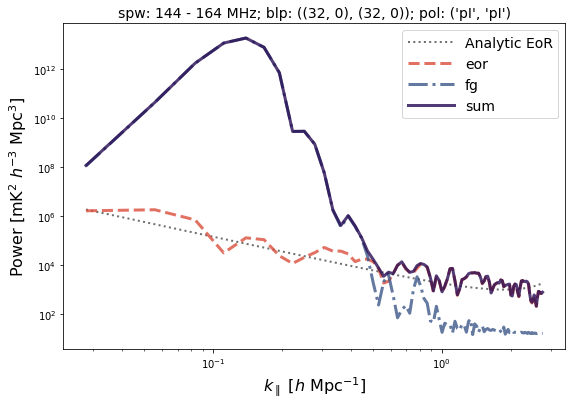

In [95]:
labels = list(data_single.keys())
colors = ['#DA4E3B', '#3D5789', '#270B52']
linewidths, linestyles = [3, 3, 3], ['--', '-.', '-']
uvp_avgs = [val['avg'] for val in data_single.values()]
plot_spectra(
    uvp_avgs, labels, 
    blps, 
    colors=colors, 
    linestyles=linestyles,         
    linewidths=linewidths, 
    alpha=0.8, 
    figsize=(9, 6)
)

fig = plt.gcf()
ax = fig.get_axes()
fig.subplots_adjust(hspace=0.2)
ax[0].legend(loc='upper right', fontsize=14, handlelength=3.25);



**Figure 6 |** Power spectrum estimates from various visibility data sets for a "single file" worth of data (66 integrations). The EoR dominates the foregrounds above about $k\sim0.5 {\rm Mpc/h}$.

## Full Day Results

In this section, we examine the resulting power spectra from performing the above analysis on a data set spanning 8 hours. Python scripts for all of the data preparation and analysis can be found in the `data_path` as defined above (see the scripts with `_multiprocessing` in their names for power spectrum retrieval; see the `preparation` scripts in the `master_data` subdirectory to see how the raw simulation files were modified to work with a modified version of the pipeline's makeflow; see the scripts in the `makeflow` subdirectory to see how the makeflow for this test was configured). A brief summary of the test steps is as follows: 

Visibilities were simulated for 24 hours over the full HERA H1C bandwidth (100 MHz - 200 MHz) over 1024 frequency channels with a uniform integration time of 10.7 seconds. Two sets of visibilities were simulated: one component is for diffuse foregrounds, simulated using the eGSM diffuse sky model; the other component is for the EoR signal, with a power spectrum amplitude that goes like $P(k) = A_0 k^{-2}$; each visibility component contains simulated observations for four polarizations (XX, XY, YX, YY). The simulations were carried out with the `RIMEz` simulation package, using the HERA dipole beam model. The individual visibility files were added together to form the "true" sky model, but only the first eight hours of the simulated data were used for this test. Finally, note that the visibility simulations are noiseless and perfectly calibrated. 
  
The power spectrum estimates were obtained using the `pspec_run` function in the `hera_pspec.pspecdata` module, exactly as defined in the "Sngle-File Test" section. This test used four spectral windows over the bandwidth 120-180 MHz and a Blackman-Harris taper for calculating the power spectrum estimates. We present the results on a per-spectral-window basis, showing both a scatter plot of power spectrum estimates on a per-baseline basis, as well as a line plot that has been averaged over all baselines. Each power spectrum presented has been incoherently averaged over the full eight hours.

### Power Spectrum Results

In this section, we load and visualize the power spectrum estimations for every data set for the full eight hours investigated in this test.

In [132]:
paths = {key: sorted(glob.glob(str(spec_path / f"*.RR.{kind}.psc"))) for key, kind in zip(['eor', 'fg', 'sum'], ['eor', 'foregrounds', 'true'])}

Let's check how many power spectra we have on disk for each kind:

In [133]:
for path_list in paths.values():
    print(len(path_list))

122
122
122


Set up a dictionary to house the spectra for all spectral windows:

In [169]:
spectra = {}

In [171]:
%%time
# incoherently average all the spectra
# each spw has 154 channels, but we'll be folding the spectra

for label, path in paths.items():
    for pth in path:
        
        uvp = get_pspec(pth)
        uvp.fold_spectra()
        
        if label not in spectra:
            spectra[label] = {spw: defaultdict(list) for spw in uvp.spw_array}
            
        for key in uvp.get_all_keys():
            spw = key[0]
            blp = key[1]
            spectra[label][spw][blp].append(uvp.get_data(key))
            
# While we have uvp around, get some other metadata out of it
spw_edges = [(spw[0], spw[1]) for spw in uvp.get_spw_ranges()]
k_paras = [uvp.get_kparas(j) for j in range(len(spw_edges))]
dlys = [uvp.get_dlys(j) for j in range(len(spw_edges))]

CPU times: user 31.3 s, sys: 7.41 s, total: 38.7 s
Wall time: 38.9 s


In [172]:
# the spectra dictionaries should have 6 spws, and each spw should have Nblp dictionaries
# each dictionary spectra[spec_file][spw][blp] should have a list with length Nfiles
# each entry in the list should have shape (66, 99) corredsponding to (Ntimes, Nkpara)

spectra_avg = {}
for label, spec_dict in spectra.items():
    spectra_avg[label] = {}
    
    for spw, spec_by_spw in spec_dict.items():
        spectra_avg[label][spw] = {}
        
        bl_avg = 0
        for blp, spec in spec_by_spw.items():
            # assert all(s.shape == (66, 99) for s in spec)

            # Reshape the spectra so we can do an easier average.
            # New arrays have the shape (Nfiles*Ntimes, Nkpara)
            spec = np.array(spec)
            spec_by_spw[blp] = spec.reshape((-1, spec.shape[-1]))
            
            spectra_avg[label][spw][blp] = np.mean(spec_by_spw[blp], axis=0)
            bl_avg += spectra_avg[label][spw][blp]
            
        spectra_avg[label][spw]['average'] = bl_avg / len(spec_dict[0])

In [173]:
Nkinds = len(spectra)
Nspws  = len(spectra['eor'])
Nblps  = len(spectra['eor'][0])

In [175]:
# now get the expected power spectrum for each spectral window
aliased_spectra = {spw: get_analytic_spectrum(uvp, spw) for spw in uvp.spw_array}

In [154]:
Nspws

4

In [178]:
spectra_avg['eor'][0].keys()

dict_keys([((21, 24), (21, 24)), ((34, 36), (34, 36)), ((6, 13), (6, 13)), ((22, 23), (22, 23)), ((14, 24), (14, 24)), ((3, 14), (3, 14)), ((21, 34), (21, 34)), ((21, 27), (21, 27)), ((28, 35), (28, 35)), ((23, 35), (23, 35)), ((7, 22), (7, 22)), ((2, 3), (2, 3)), ((11, 16), (11, 16)), ((15, 32), (15, 32)), ((10, 28), (10, 28)), ((26, 34), (26, 34)), ((0, 9), (0, 9)), ((4, 25), (4, 25)), ((9, 29), (9, 29)), ((3, 25), (3, 25)), ((27, 29), (27, 29)), ((8, 32), (8, 32)), ((6, 31), (6, 31)), ((15, 31), (15, 31)), ((1, 19), (1, 19)), ((23, 28), (23, 28)), ((20, 29), (20, 29)), ((19, 31), (19, 31)), ((14, 30), (14, 30)), ((1, 28), (1, 28)), ((9, 32), (9, 32)), ((0, 23), (0, 23)), ((8, 34), (8, 34)), ((1, 29), (1, 29)), ((12, 13), (12, 13)), ((6, 12), (6, 12)), ((5, 35), (5, 35)), ((3, 34), (3, 34)), ((8, 27), (8, 27)), ((13, 35), (13, 35)), ((5, 13), (5, 13)), ((6, 19), (6, 19)), ((0, 32), (0, 32)), ((5, 20), (5, 20)), ((6, 26), (6, 26)), ((6, 9), (6, 9)), ((9, 36), (9, 36)), ((1, 33), (1, 3

In [201]:
def plot_avg_spectra(spectra_avg, resid=False, xlim=None, ylim=None):
    # for now, let's only plot the abscal, smoothed abscal, simple cal, and true power spectra
    colors = ['#DA4E3B', '#3D5789', '#270B52']
    alphas = (0.5, 0.6, 0.6)

    linestyles = ('-', ':', '--', '-', '-', '-')
    lws = (4, 4, 4, 6, 6, 6)

    # bundle these up into a tuple of things to be iterated over
    plot_iterator = lambda : zip(spec_to_plot.values(), labels, colors, alphas, linestyles, lws)

    # create a figure and axes objects
    fig = plt.figure(figsize=(15, 5.8 * Nspws))
    axes = fig.subplots(Nspws)

    # setup stuff
    for j in range(Nspws):
        ax = axes[j]
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        ax.grid(b=True, which="major", axis="y")
        ax.grid(b=True, which="both", axis="x")
        fmin, fmax = spw_edges[j]
        ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                      "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                      fontsize=12)

        ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
        
        
        ax.set_xscale('log')
        if not resid:
            ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
            ax.set_yscale('log')
        else:
            ax.set_ylabel(r"Fractional Residual Power", fontsize=12)
            
    # plot all the ("measured") things    
    for (label, spec), color, alpha, ls, lw in zip(spectra_avg.items(), colors, alphas, linestyles, lws):
        for spw, kparallel in enumerate(k_paras):
            ax = axes[spw]
            
            if resid:
                ax.plot(kparallel, (np.abs(spec[spw]['average']) - aliased_spectra[spw])/aliased_spectra[spw], lw=lw, ls=ls, color=color, alpha=alpha, label=label)
                ax.axhline(0, lw=2, color='k')
            else:
                ax.plot(kparallel, np.abs(spec[spw]['average']), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
                ax.plot(kparallel, aliased_spectra[spw], color='k', lw=4, ls='--', alpha=0.3, label="expected")
            
            ax.legend(ncol=2)

        

    plt.tight_layout()

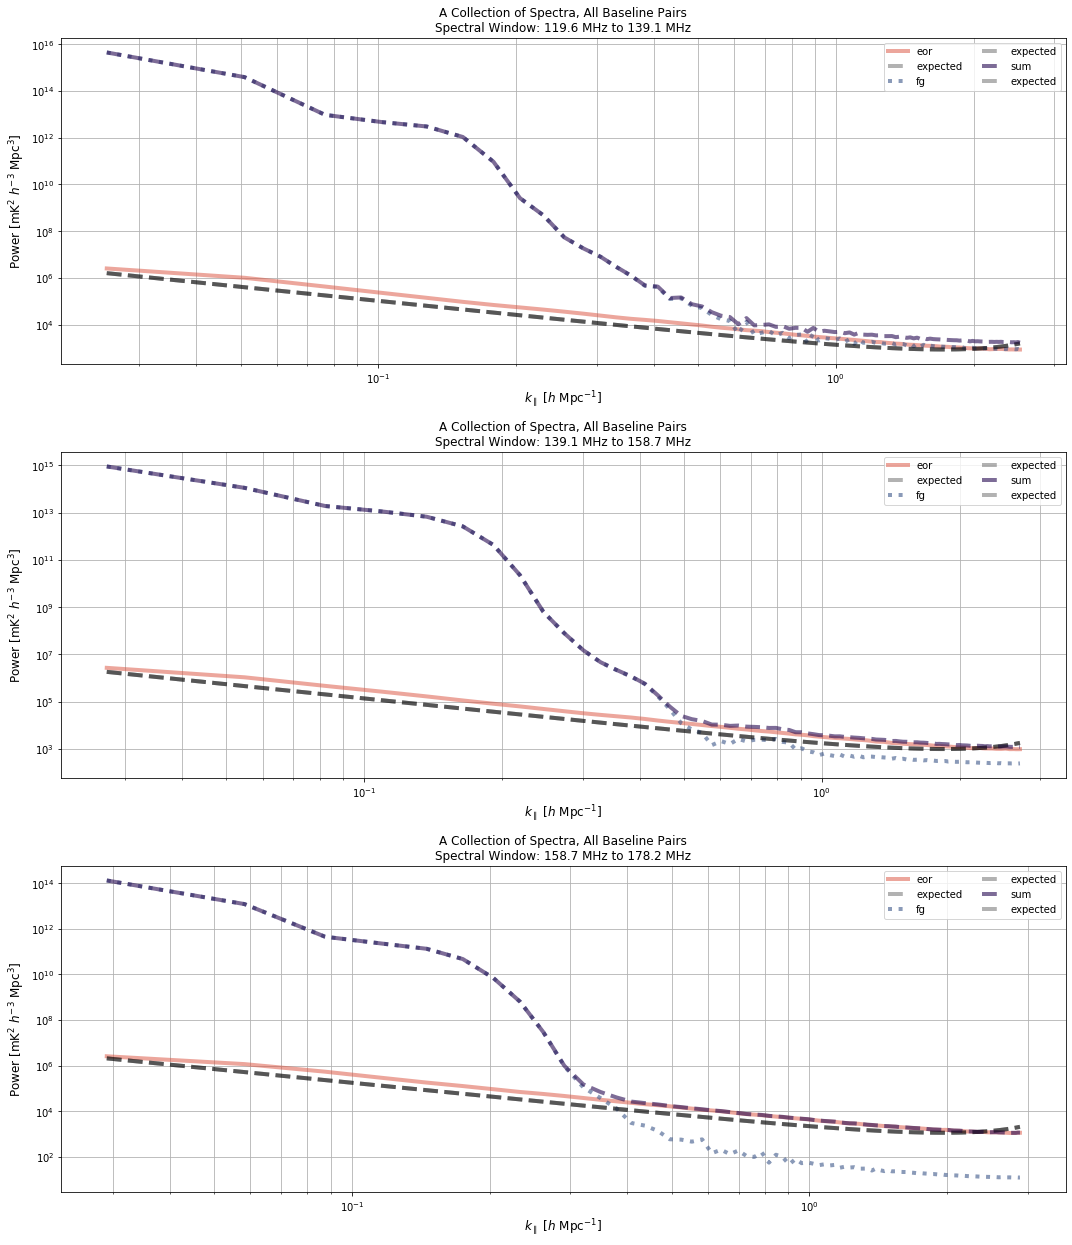

In [193]:
plot_avg_spectra(spectra_avg);

# plt.show()
# save_path = os.path.join(plot_path, "full_day_with_aliased_expectation_all_kparas.pdf")
# fig.savefig(save_path)
# fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 11 |** Power spectra for the three spectral windows used in this analysis. Only auto-baseline pairs were used for power spectrum estimation. Each line notes the power spectrum estimate, incoherently averaged in time over the full eight hours of simulated data used and averaged over all baseline pairs. We only see EoR dominate the signal at some $k$-modes in the upper spectral window.

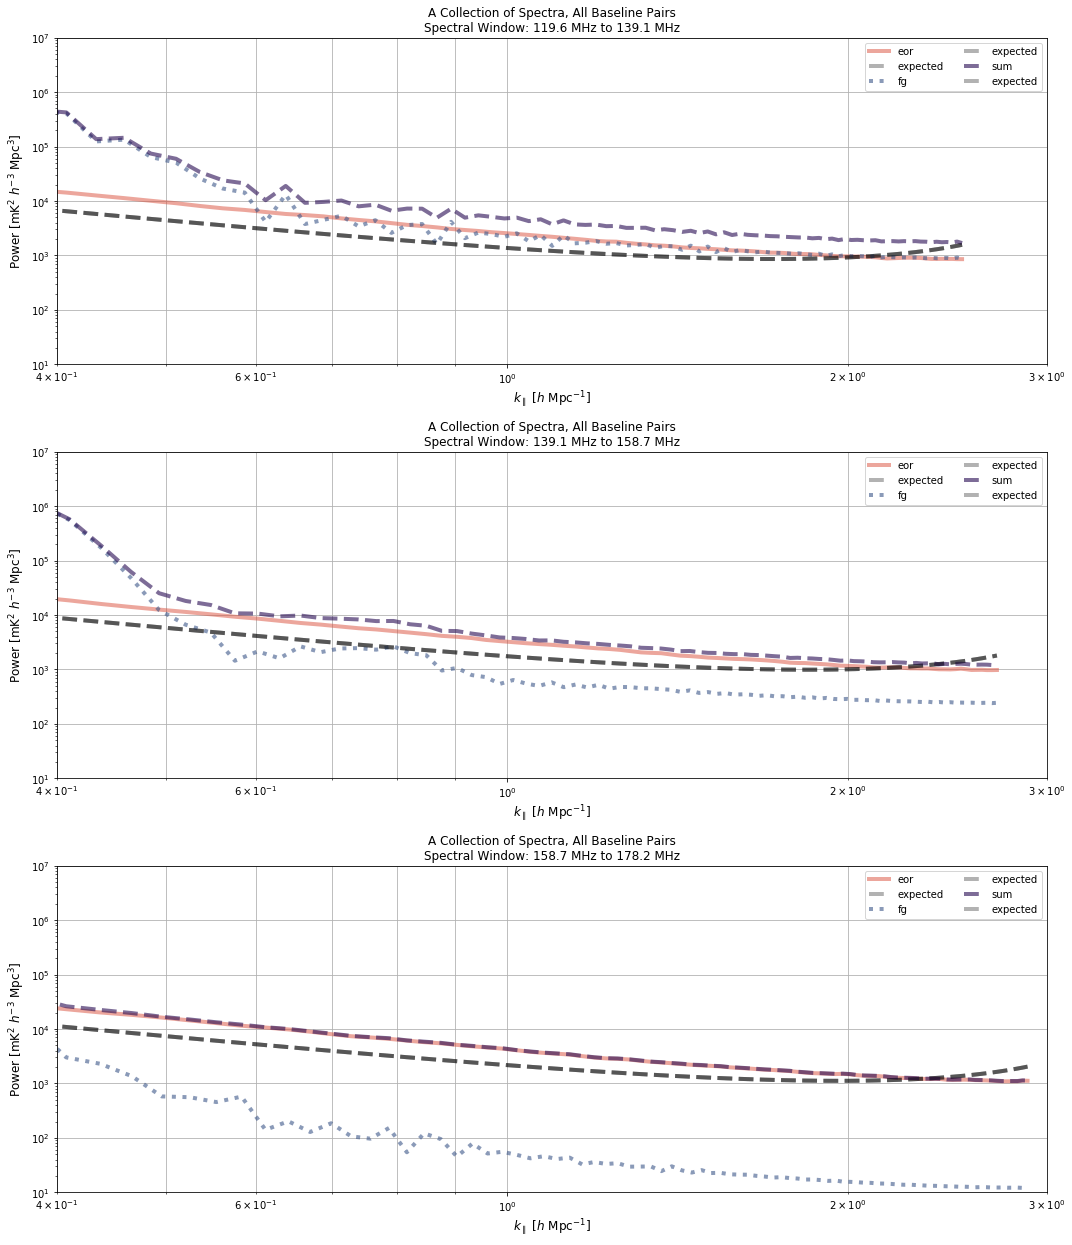

In [194]:
plot_avg_spectra(spectra_avg, xlim=(0.4, 3), ylim=(10**1, 10**7))

# # create a figure and axes objects
# fig = plt.figure(figsize=(15,35))
# axes = fig.subplots(6)

# # setup stuff
# for j in range(6):
#     ax = axes[j]
#     ax.set_xlim(0.4, k_paras[j].max())
#     ax.set_ylim(10**2.75, 10**5.5)
#     ax.grid(b=True, which="major", axis="y")
#     ax.grid(b=True, which="both", axis="x")
#     fmin, fmax = spw_edges[j]
#     ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
#                   "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
#                   fontsize=12)
#     ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
#     #ax.set_xlabel("Delay [ns]", fontsize=12)
#     ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
    
# # plot all the ("measured") things    
# for spec_dict, label, color, alpha, ls, lw in plot_iterator():
#     for spw, kparas in enumerate(k_paras):
#         ax = axes[spw]
#         spec_by_spw = spec_dict[spw]
#         bl_avg = []
#         for spec in spec_by_spw.values():
#             bl_avg.append(spec.mean(axis=0))
#         bl_avg = np.asarray(bl_avg).mean(axis=0)
#         ax.loglog(kparas, np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        
# # now plot the expected power spectra
# for spw, kparas in enumerate(k_paras):
#     ax = axes[spw]
#     ax.loglog(kparas, aliased_spectra[spw], color='k', lw=4, ls='--', alpha=0.3, label="expected")
#     ax.legend(ncol=2)

# plt.tight_layout()
# plt.show()
# save_path = os.path.join(plot_path, "full_day_with_aliased_expectation.pdf")
# fig.savefig(save_path)
# fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 12 |** Same plot as above, but with the viewing window restricted to $k_\parallel$ values greater than 0.4 $h$ Mpc$^{-1}$.

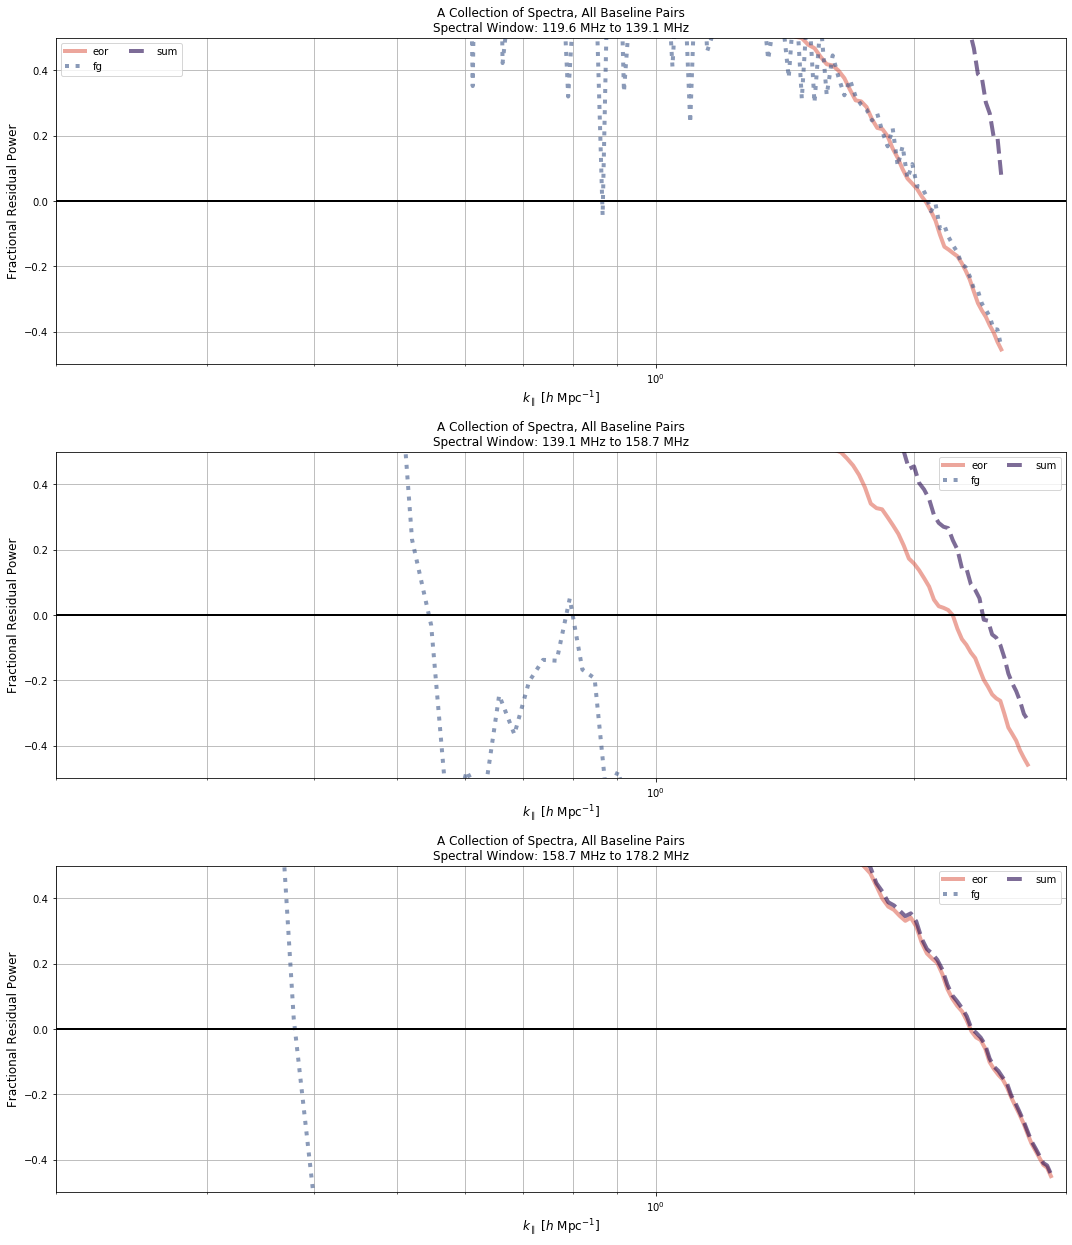

In [202]:
# Plot residual
plot_avg_spectra(spectra_avg, resid=True, xlim=(0.2, 3), ylim=(-0.5, 0.5))

In [67]:
# calculate the average of the true spectrum
true_spec_bl_avg = {}
for spw, spec_dict in true_spectra.items():
    bl_avg = []
    for spec in spec_dict.values():
        bl_avg.append(spec.mean(axis=0))
    true_spec_bl_avg[spw] = np.asarray(bl_avg).mean(axis=0)

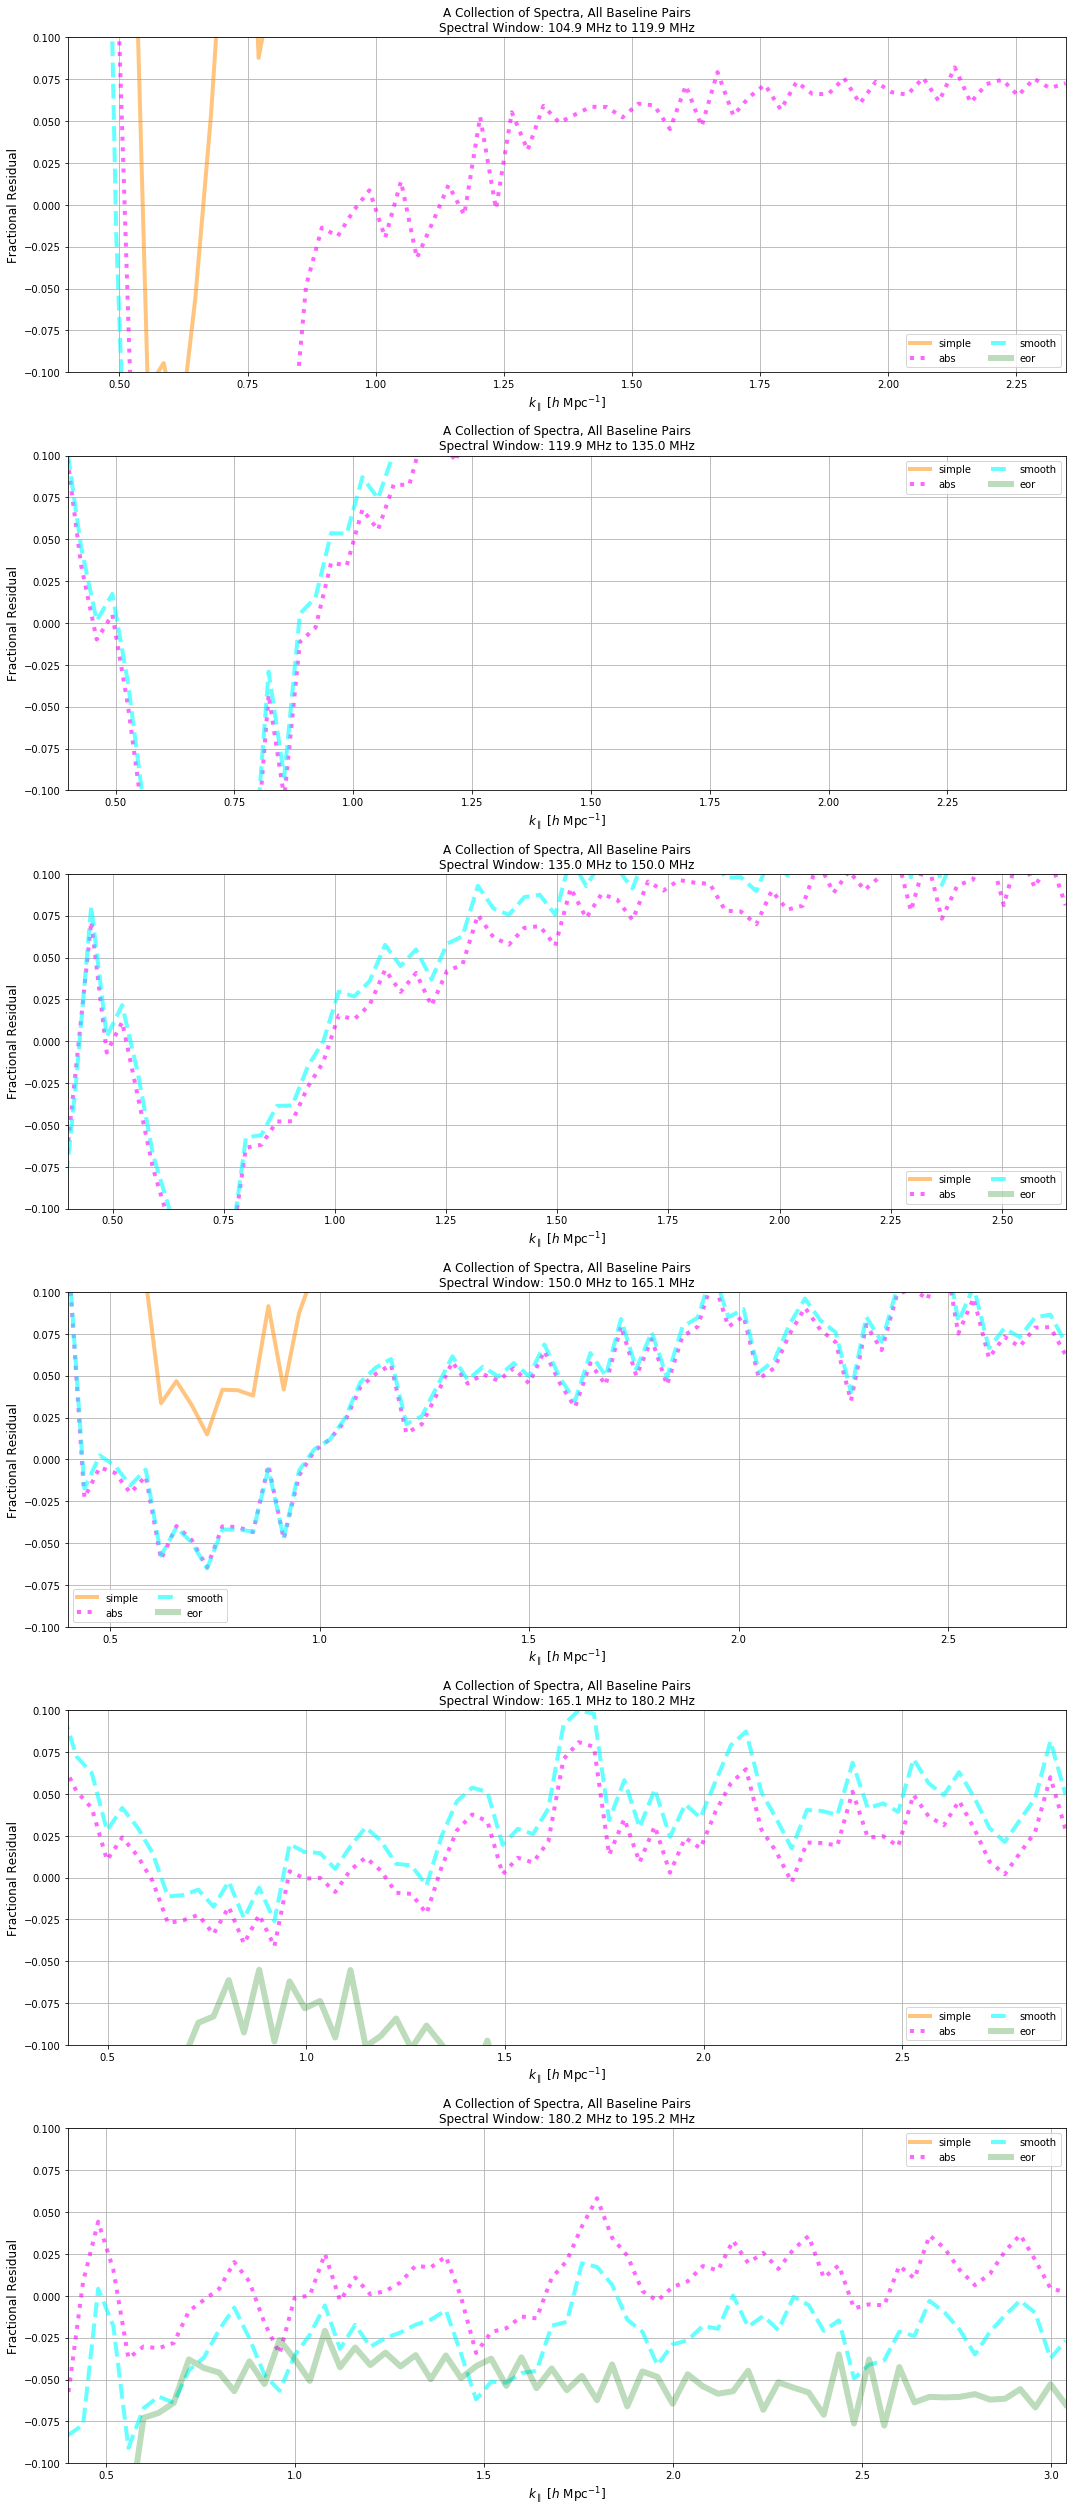

In [68]:
# create a figure and axes objects
fig = plt.figure(figsize=(15,35))
axes = fig.subplots(6)

# setup stuff
for j in range(6):
    ax = axes[j]
    ax.set_xlim(0.4, k_paras[j].max())
    ax.set_ylim(-0.1, 0.1)
    ax.grid(b=True, which="major", axis="y")
    ax.grid(b=True, which="both", axis="x")
    fmin, fmax = spw_edges[j]
    ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                  "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                  fontsize=12)
    ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
    ax.set_ylabel("Fractional Residual", fontsize=12)
    
# plot all the ("measured") things    
for spec_dict, label, color, alpha, ls, lw in plot_iterator():
    if label in ("fg", "true",):
        continue
    for spw, kparas in enumerate(k_paras):
        ax = axes[spw]
        spec_by_spw = spec_dict[spw]
        bl_avg = []
        for spec in spec_by_spw.values():
            bl_avg.append(spec.mean(axis=0))
        bl_avg = np.array(bl_avg).mean(axis=0)
        fractional_error = np.real(bl_avg - true_spec_bl_avg[spw])
        fractional_error /= np.real(true_spec_bl_avg[spw])
        ax.plot(kparas, fractional_error, lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        ax.legend(ncol=2)

plt.tight_layout()
plt.show()
save_path = os.path.join(plot_path, "full_day_residuals.pdf")
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 13 |** Fractional residuals, measured relative to the true (perfectly calibrated) power spectrum estimate.

## Frequency-Dependent EoR Amplitude

In the previous section, we found issues regarding the extraction of the expected EoR signal, likely due to issues regarding windowing and the difference in dynamic range of EoR and foregrounds. In this section, we perform the same analysis as in the previous section, but with an amplified, frequency-dependent EoR signal.

In [73]:
simple_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor*simple*.psc")))
abs_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor*.abs_vis.psc")))
smooth_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor*smooth*.psc")))
uncal_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor*uncal.psc")))
omni_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor*omni*.psc")))
true_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor.true.psc")))
eor_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.freq_dep_eor.psc")))
fg_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.fg_only.psc")))

In [74]:
globs = (simple_spec_glob, abs_spec_glob, smooth_spec_glob, uncal_spec_glob, 
         omni_spec_glob, true_spec_glob, eor_spec_glob, fg_spec_glob)

In [75]:
for spec_glob in globs:
    print(len(spec_glob))

269
269
269
269
269
269
269
269


In [76]:
%%time
# incoherently average all the spectra
# each spw has 154 channels, but we'll be folding the spectra

# initialize some dictionaries
simple_cal_spectra = {spw: {} for spw in range(6)}
abs_cal_spectra = {spw: {} for spw in range(6)}
smooth_abs_cal_spectra = {spw: {} for spw in range(6)}
omni_cal_spectra = {spw: {} for spw in range(6)}
uncal_spectra = {spw: {} for spw in range(6)}
true_spectra = {spw: {} for spw in range(6)}
eor_spectra = {spw: {} for spw in range(6)}
fg_spectra = {spw: {} for spw in range(6)}

# some stuff for making things easy
spectra = {"simple" : simple_cal_spectra,
           "abs" : abs_cal_spectra,
           "smooth" : smooth_abs_cal_spectra, 
           "uncal" : uncal_spectra,
           "omni" : omni_cal_spectra,
           "true" : true_spectra,
           "eor" : eor_spectra,
           "fg" : fg_spectra}

labels = tuple(spectra.keys())
assert len(labels) == len(globs)

skip_data = ("uncal", "omni")
#skip_data = (key for key in spectra.keys() if key != "eor")

for label, spec_glob in zip(labels, globs):
    if label in skip_data:
        continue
    spec_by_spw = spectra[label]
    for spec_file in spec_glob:
        psc = hera_pspec.container.PSpecContainer(spec_file, keep_open=False)
        uvp = psc.get_pspec(psc.groups()[0])[0]
        uvp.fold_spectra()
        for key in uvp.get_all_keys():
            spw = key[0]
            blp = key[1]
            try:
                spec_by_spw[spw][blp].append(uvp.get_data(key))
            except KeyError:
                spec_by_spw[spw][blp] = [uvp.get_data(key),]
        
# get the k_parallel arrays
k_paras = [uvp.get_kparas(spw) for spw in range(6)]

# delete the pspec container and power spectra
del psc, uvp

CPU times: user 12min 5s, sys: 3min 59s, total: 16min 4s
Wall time: 30min 18s


In [77]:
# the spectra dictionaries should have 6 spws, and each spw should have Nblp dictionaries
# each dictionary spectra[spec_file][spw][blp] should have a list with length Nfiles
# each entry in the list should have shape (10, 76)
for label, spec_dict in spectra.items():
    if label in skip_data:
        continue
    for spw in spec_dict.keys():
        for blp in spec_dict[spw].keys():
            for spec in spec_dict[spw][blp]:
                assert spec.shape == (10,76)
                
# now let's re-shape from (Nfiles, Ntimes, Ndlys) to (Nfiles * Ntimes, Ndlys)
for label, spec_dict in spectra.items():
    if label in skip_data:
        continue
    for spec_by_spw in spec_dict.values():
        for blp, spec in spec_by_spw.items():
            spec = np.array(spec)
            new_shape = (spec.shape[0] * spec.shape[1], spec.shape[2])
            spec_by_spw[blp] = spec.reshape(new_shape)
            
# in the end we have an array of shape (Nspw, Nblps, Nfiles * Ntimes, Ndlys)

In [78]:
# get the spectral window edges, k_parallel values, and delays
psc = hera_pspec.container.PSpecContainer(eor_spec_glob[0], keep_open=False)
uvp = psc.get_pspec(psc.groups()[0])[0]
uvp.fold_spectra()
spw_edges = [(spw[0], spw[1]) for spw in uvp.get_spw_ranges()]
k_paras = [uvp.get_kparas(j) for j in range(6)]
#k_paras = [uvp.get_kparas(j, little_h=False) for j in range(6)]
dlys = [uvp.get_dlys(j) for j in range(6)]

# now get the expected power spectrum for each spectral window
aliased_spectra = {}
for j, kparas in enumerate(k_paras):
    # get the frequencies in the spectral window
    spw = uvp.freq_array[j*154 : (j+1)*154] # 154 channels per spectral window
    
    # get redshift at center of spectral window
    z = cosmo.f2z(np.mean(spw))
    
    # get co-moving distances sampled along LoS
    sampled_distances = np.array([cosmo.DC(z) for z in cosmo.f2z(spw)])
    
    # convert to approximate sampling frequency
    ks_est = np.pi/np.mean(np.abs(np.diff(sampled_distances)))
    
    # calculate aliased power spectrum
    aliased_spectra[j] = aliased_power_spectrum(kparas, ks_est, z=z, cosmo=cosmo, freq_dep=True)
    
del psc, uvp

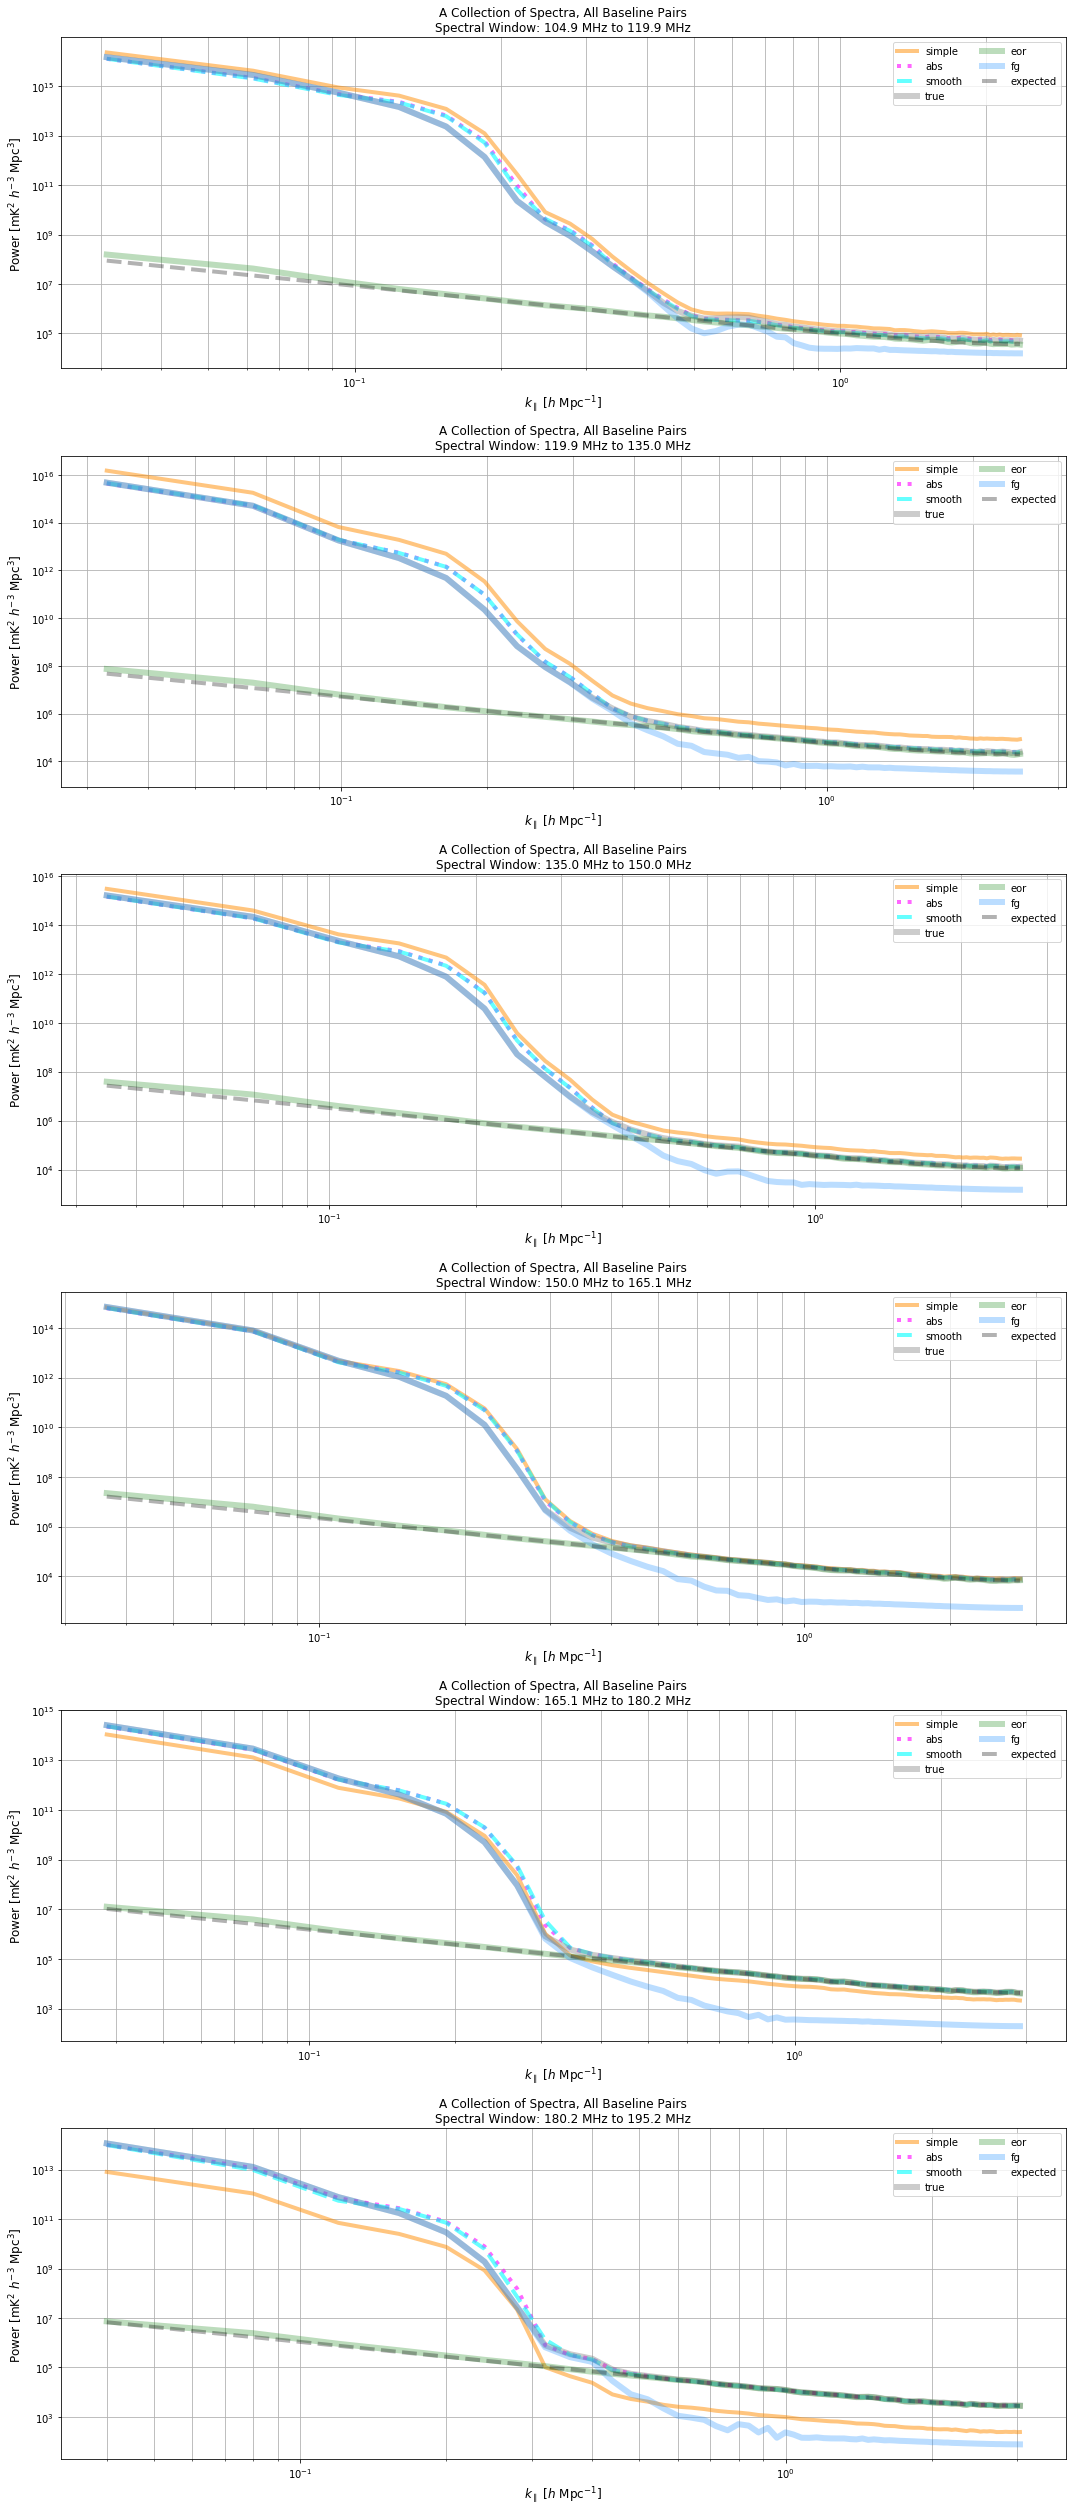

In [79]:
# for now, let's only plot the abscal, smoothed abscal, simple cal, and true power spectra
labels = ("simple", "abs", "smooth", "true", "eor", "fg")
#labels = ("eor", "fg",)
spec_to_plot = {label : spectra[label] for label in labels}
#colors = ("forestgreen", "dodgerblue",)
#alphas = (0.3, 0.3,)
#linestyles = ('-', '-',)
#lws = (6, 6,)
colors = ("darkorange", "magenta", "cyan", "gray", "forestgreen", "dodgerblue")
alphas = (0.5, 0.6, 0.6, 0.4, 0.3, 0.3)
linestyles = ('-', ':', '--', '-', '-', '-')
lws = (4, 4, 4, 6, 6, 6)

# bundle these things into an iterator
plot_iterator = lambda : zip(spec_to_plot.values(), labels, colors, alphas, linestyles, lws)

# create a figure and axes objects
fig = plt.figure(figsize=(15,35))
axes = fig.subplots(6)

# setup stuff
for j in range(6):
    ax = axes[j]
    #ax.set_xlim(0.4, k_paras[j].max())
    #ax.set_ylim(10**2.75, 10**5.5)
    ax.grid(b=True, which="major", axis="y")
    ax.grid(b=True, which="both", axis="x")
    fmin, fmax = spw_edges[j]
    ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                  "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                  fontsize=12)
    ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
    #ax.set_xlabel("Delay [ns]", fontsize=12)
    ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
    
# plot all the ("measured") things    
for spec_dict, label, color, alpha, ls, lw in plot_iterator():
    for spw, kparas in enumerate(k_paras):
        ax = axes[spw]
        spec_by_spw = spec_dict[spw]
        bl_avg = []
        for blp, spec in spec_by_spw.items():
            #ax.loglog(kparas, np.abs(spec.mean(axis=0)), marker='o', ms=2, color=color, alpha=0.3, lw=0)
            #ax.semilogy(dlys[spw], np.abs(spec.mean(axis=0)), marker='o', ms=2, color=color, alpha=0.3, lw=0)
            bl_avg.append(spec.mean(axis=0))
        bl_avg = np.array(bl_avg).mean(axis=0)
        ax.loglog(kparas, np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        #ax.semilogy(dlys[spw], np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        
# now plot the expected power spectra
for spw, kparas in enumerate(k_paras):
    ax = axes[spw]
    ax.loglog(kparas, aliased_spectra[spw], color='k', lw=4, ls='--', alpha=0.3, label="expected")
    ax.legend(ncol=2)
plt.tight_layout()
plt.show()
save_path = os.path.join(plot_path, "full_day_with_aliased_expectation_all_kparas_freq_dep_eor.pdf")
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 15 |** Same as Fig. 11, but for the boosted EoR spectrum.

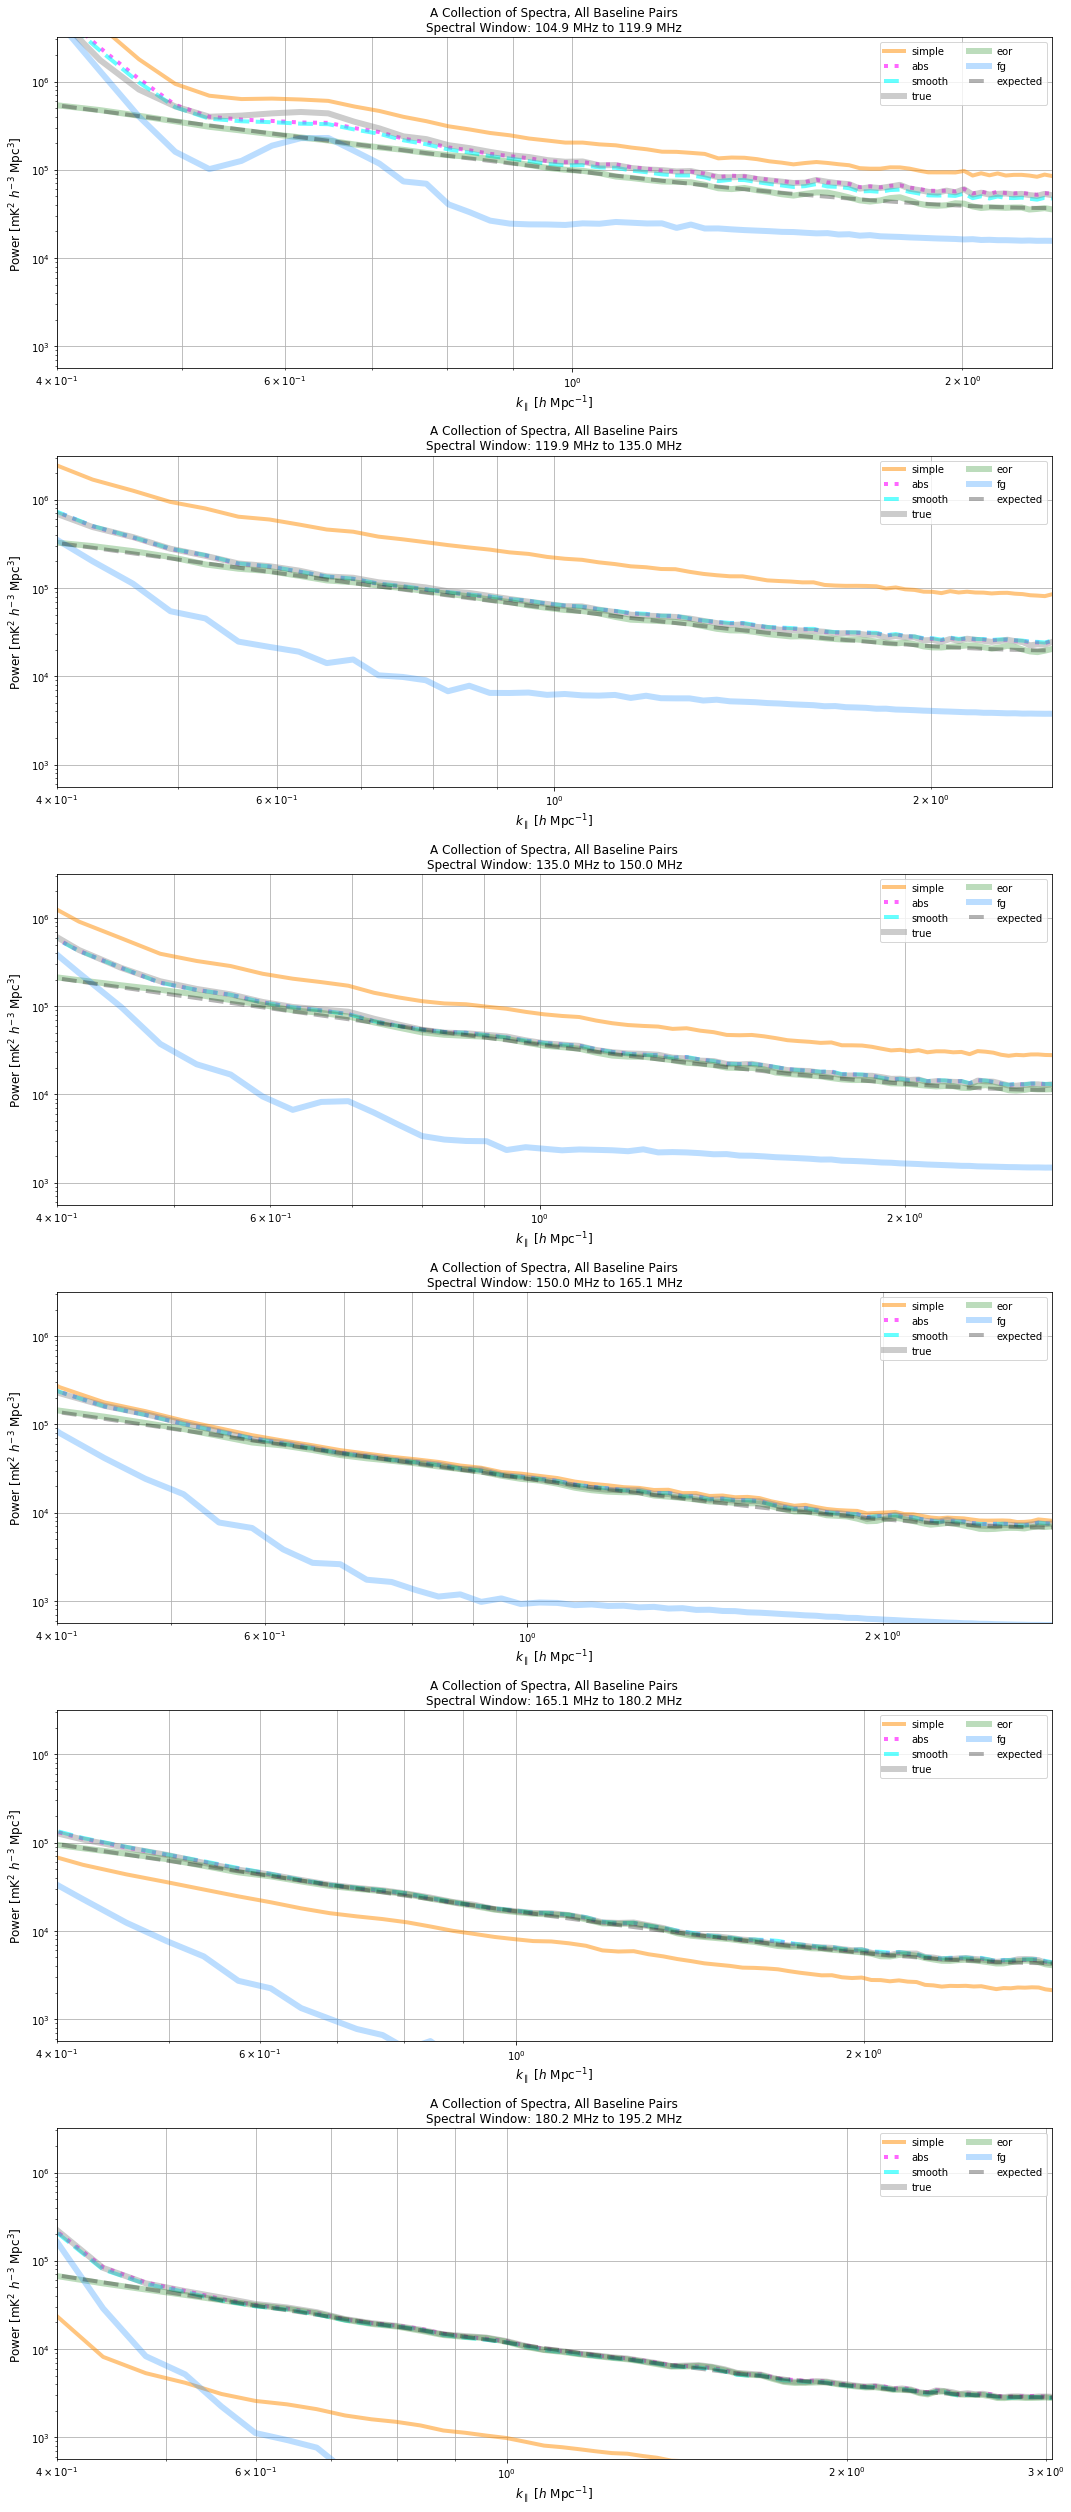

In [80]:
# create a figure and axes objects
fig = plt.figure(figsize=(15,35))
axes = fig.subplots(6)

# setup stuff
for j in range(6):
    ax = axes[j]
    ax.set_xlim(0.4, k_paras[j].max())
    ax.set_ylim(10**2.75, 10**6.5)
    ax.grid(b=True, which="major", axis="y")
    ax.grid(b=True, which="both", axis="x")
    fmin, fmax = spw_edges[j]
    ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                  "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                  fontsize=12)
    ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
    #ax.set_xlabel("Delay [ns]", fontsize=12)
    ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
    
# plot all the ("measured") things    
for spec_dict, label, color, alpha, ls, lw in plot_iterator():
    for spw, kparas in enumerate(k_paras):
        ax = axes[spw]
        spec_by_spw = spec_dict[spw]
        bl_avg = []
        for blp, spec in spec_by_spw.items():
            bl_avg.append(spec.mean(axis=0))
        bl_avg = np.array(bl_avg).mean(axis=0)
        ax.loglog(kparas, np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        
# now plot the expected power spectra
for spw, kparas in enumerate(k_paras):
    ax = axes[spw]
    ax.loglog(kparas, aliased_spectra[spw], color='k', lw=4, ls='--', alpha=0.3, label="expected")
    ax.legend(ncol=2)
plt.tight_layout()
plt.show()
save_path = os.path.join(plot_path, "full_day_with_aliased_expectation_freq_dep_eor.pdf")
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 16 |** Same as Fig. 12, but for the boosted EoR spectrum.

In [81]:
# calculate the average of the true spectrum
true_spec_bl_avg = {}
for spw, spec_dict in true_spectra.items():
    bl_avg = []
    for spec in spec_dict.values():
        bl_avg.append(spec.mean(axis=0))
    true_spec_bl_avg[spw] = np.asarray(bl_avg).mean(axis=0)

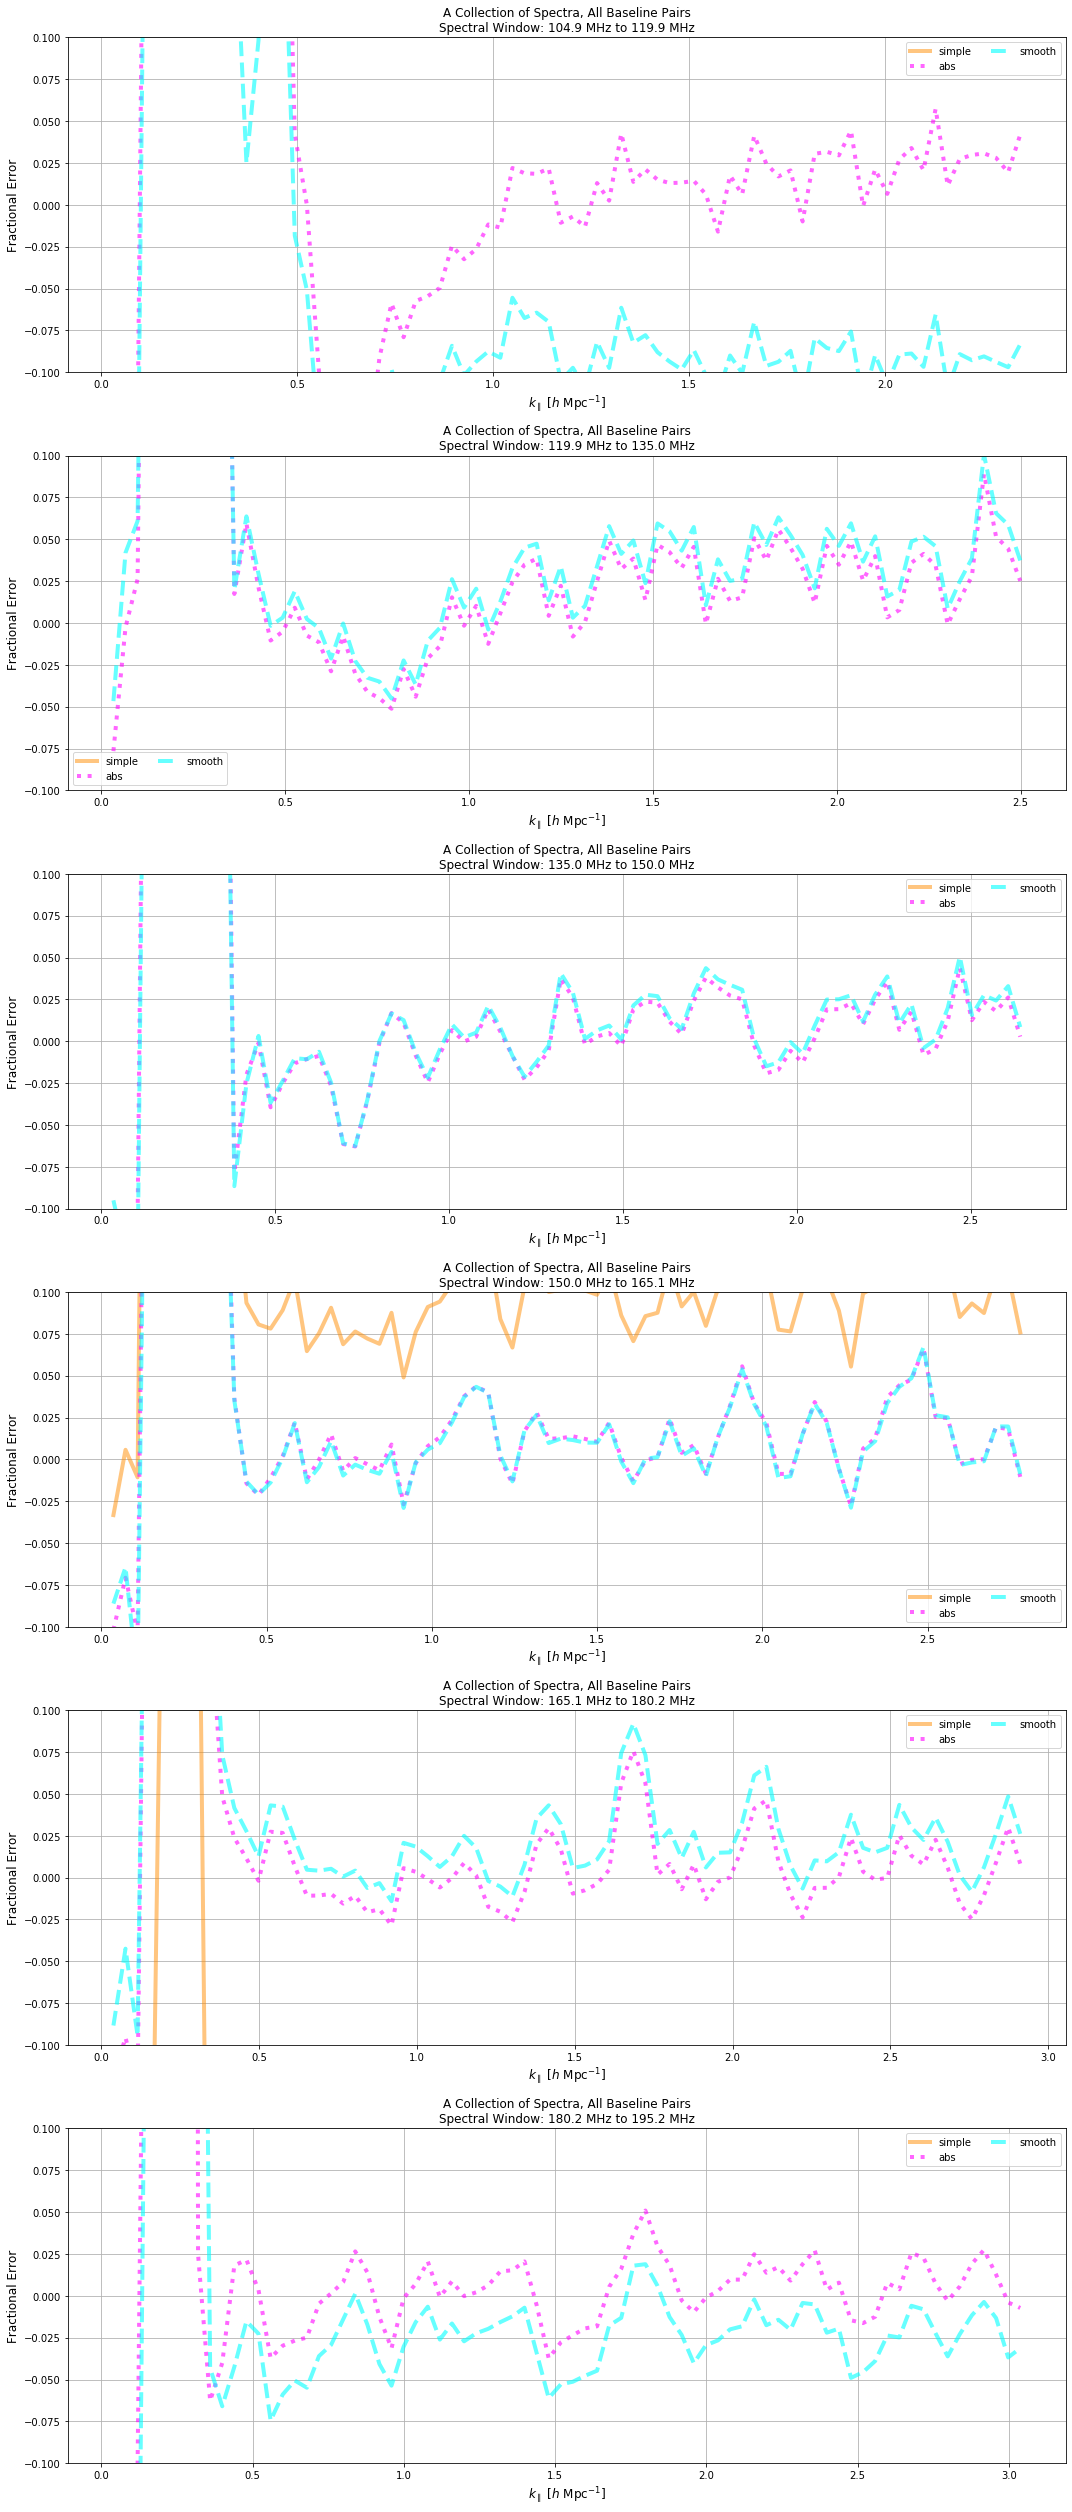

In [82]:
# create a figure and axes objects
fig = plt.figure(figsize=(15,35))
axes = fig.subplots(6)

# setup stuff
for j in range(6):
    ax = axes[j]
    #ax.set_xlim(0.4, k_paras[j].max())
    ax.set_ylim(-0.1, 0.1)
    ax.grid(b=True, which="major", axis="y")
    ax.grid(b=True, which="both", axis="x")
    fmin, fmax = spw_edges[j]
    ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                  "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                  fontsize=12)
    ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
    ax.set_ylabel("Fractional Error", fontsize=12)
    
# plot all the ("measured") things    
for spec_dict, label, color, alpha, ls, lw in plot_iterator():
    if label in ("fg", "true", "eor",):
        continue
    for spw, kparas in enumerate(k_paras):
        ax = axes[spw]
        spec_by_spw = spec_dict[spw]
        bl_avg = []
        for blp, spec in spec_by_spw.items():
            #ax.loglog(kparas, np.abs(spec.mean(axis=0)), marker='o', ms=2, color=color, alpha=0.3, lw=0)
            #ax.semilogy(dlys[spw], np.abs(spec.mean(axis=0)), marker='o', ms=2, color=color, alpha=0.3, lw=0)
            bl_avg.append(spec.mean(axis=0))
        bl_avg = np.asarray(bl_avg).mean(axis=0)
        fractional_error = (np.real(bl_avg) - np.real(true_spec_bl_avg[spw]))
        fractional_error /= np.real(true_spec_bl_avg[spw])
        ax.plot(kparas, fractional_error, lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        ax.legend(ncol=2)

plt.tight_layout()
plt.show()
save_path = os.path.join(plot_path, "full_day_residuals_freq_dep_eor.pdf")
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 17 |** Plot of the fractional residuals of power spectra, measured relative to the true (perfectly calibrated) power spectrum estimate.

In [83]:
# include some sort of summary statistics: mean fractional difference over entire spw;
# mean fractional diff over spw with k > 0.5; etc

In [95]:
del spectra, simple_cal_spectra, abs_cal_spectra, smooth_abs_cal_spectra
del omni_cal_spectra, uncal_spectra, true_spectra, eor_spectra, fg_spectra